### Import library

In [768]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Part 1: Prediction with historical data

In [742]:
window_size = 12    # Use the last 12 hours to predict the next hour
horizon = 180       # Take 180 hours for the test

### Data preprocessing

In [743]:
# Function to preprocess historical data
def preprocess_true_data(df):
    new_df = df.copy()
    new_df['dayofweek'] = new_df['date'].dt.dayofweek           # Day of the week (0 to 6)
    new_df['hourofday'] = new_df['date'].dt.hour                # Time of day (0 to 23)
    new_df['dayofyear'] = new_df['date'].dt.dayofyear           # day of the year (1 to 365)
    return new_df

In [744]:
df_price = pd.read_parquet("../data/CYTECH/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet").reset_index()
df_price_preprocessed = preprocess_true_data(df_price)
df_price_preprocessed.head(40)

,date,price,dayofweek,hourofday,dayofyear
0,2016-12-31 23:00:00+00:00,58.82,5,23,366
1,2017-01-01 00:00:00+00:00,58.23,6,0,1
2,2017-01-01 01:00:00+00:00,51.95,6,1,1
3,2017-01-01 02:00:00+00:00,47.27,6,2,1
4,2017-01-01 03:00:00+00:00,45.49,6,3,1
5,2017-01-01 04:00:00+00:00,44.50,6,4,1
6,2017-01-01 05:00:00+00:00,44.50,6,5,1
7,2017-01-01 06:00:00+00:00,44.72,6,6,1
8,2017-01-01 07:00:00+00:00,44.22,6,7,1
9,2017-01-01 08:00:00+00:00,42.06,6,8,1


In [745]:
# Split dataset (train and test)
def split_data(df, horizon):
    train_df = df[:-horizon]
    test_df = df[-horizon:]
    return train_df, test_df

## Prepare training data

In [746]:
# Creating np.array to format data for the model
def create_input_output(df, window_size):
    X = []
    y = []
    
    # X = price of the last 12 hours, day of the week, hour, day of the year
    for i in range(window_size, len(df)):
        
        # Retrieve the 12 last price
        x_data = df.iloc[i-window_size:i][['price']].values.flatten()
    
        # Data context of the hour we will predict
        x_data = np.concatenate([x_data, [df.iloc[i]['dayofweek'], df.iloc[i]['hourofday'], df.iloc[i]['dayofyear']]])
        
        # y: electricity price at the next hour
        y.append(df.iloc[i]['price'])
        X.append(x_data)
    
    return np.array(X), np.array(y)

In [747]:
train_data, test_data = split_data(df_price_preprocessed, horizon)

X_train, y_train = create_input_output(train_data, window_size)

print(X_train)
print(y_train)

[[ 58.82  58.23  51.95 ...   6.    11.     1.  ]
 [ 58.23  51.95  47.27 ...   6.    12.     1.  ]
 [ 51.95  47.27  45.49 ...   6.    13.     1.  ]
 ...
 [ 33.15  30.39  28.04 ...   3.     8.   359.  ]
 [ 30.39  28.04   7.59 ...   3.     9.   359.  ]
 [ 28.04   7.59  10.91 ...   3.    10.   359.  ]]
[49.57 48.69 46.91 ... 46.68 44.74 41.55]


## Prepare test data

In [748]:
price = test_data['price'][:window_size].to_numpy()

hour = test_data.iloc[window_size]['hourofday']
dayofweek = test_data.iloc[window_size]['dayofweek']
dayofyear = test_data.iloc[window_size]['dayofyear']

X_test_first = np.concatenate([price, [dayofweek, hour, dayofyear]])
y_test = test_data[window_size:]

## Model 1 : Conv1D

In [749]:
# Function to create the Conv1D model architecture
def create_conv1d_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))  # Output = price of the next hour
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

In [750]:
# Create model
input_shape = (X_train.shape[1], 1)
model = create_conv1d_model(input_shape)

# Summary of the model
model.summary()

c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_55 (Conv1D)              │ (None, 13, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_51 (Flatten)            │ (None, 832)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 64)             │        53,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,633 (209.50 KB)

 Trainable params: 53,633 (209.50 KB)

 Non-trainable params: 0 (0.00 B)

### Training model

In [751]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_reshaped, y_train, test_size=0.2, random_state=42)        # Split dataset (train, validation)

# Use early_stopping to stop the model if there isn't improvement during 5 epoch and avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_split, y_train_split,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_split, y_val_split),  # Validation data
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 78.7798 - mae: 5.1927 - val_loss: 21.4520 - val_mae: 2.9746
Epoch 2/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 23.2495 - mae: 3.1436 - val_loss: 22.5051 - val_mae: 3.1420
Epoch 3/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 24.6307 - mae: 3.2022 - val_loss: 22.4603 - val_mae: 3.2496
Epoch 4/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 22.1655 - mae: 3.0832 - val_loss: 19.0258 - val_mae: 2.7601
Epoch 5/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 20.4217 - mae: 2.9627 - val_loss: 18.1455 - val_mae: 2.6878
Epoch 6/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 20.0704 - mae: 2.8805 - val_loss: 18.9251 - val_mae: 2.8302
Epoch 7/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 23.0394 - mae: 3.0374 - val_loss: 18.9470 - val_mae: 2.7751
Epoch 8/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 18.5792 - mae: 2.7923 - val_loss: 17.6640 - val_mae: 2.6654
Epoch 9/50
872/872 ━━━━━━━━━━━━━━━━━━━━

In [766]:
# Use to save the trained model
model.save_weights('model_weights.weights.h5')

In [671]:
model = create_conv1d_model(input_shape)

# Load model
model.load_weights('model_weights.weights.h5')

c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Model 2 : GRU (enhanced RNN)

In [688]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model
def create_gru_model(input_shape):
    gru_model = Sequential()

    gru_model.add(GRU(64, return_sequences=True, input_shape=input_shape, activation='relu'))
    gru_model.add(Dropout(0.2))  # Regularisation
    
    gru_model.add(GRU(32, return_sequences=False, activation='relu'))
    gru_model.add(Dropout(0.2)) # Regularisation
    
    gru_model.add(Dense(64, activation='relu'))
    gru_model.add(Dense(1)) # Output = price of the next hour
    
    gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return gru_model


In [689]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

X_train_gru_reshape = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_train_gru_split, X_val_gru_split, y_train_gru_split, y_val_gru_split = train_test_split(X_train_gru_reshape, y_train, test_size=0.2, random_state=42)


input_shape = (X_train.shape[1], 1)
gru_model = create_gru_model(input_shape)

gru_model.summary()

# Avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = gru_model.fit(
    X_train_gru_split, y_train_gru_split,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_gru_split, y_val_gru_split),  # Validation data
    verbose=1,
    callbacks=[early_stopping]
)

c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_28 (GRU)                    │ (None, 15, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_29 (GRU)                    │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,449 (95.50 KB)

 Trainable params: 24,449 (95.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 295.7965 - mae: 10.5099 - val_loss: 135.1747 - val_mae: 9.9107
Epoch 2/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 35.8686 - mae: 4.1034 - val_loss: 88.5395 - val_mae: 7.9260
Epoch 3/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 31.5399 - mae: 3.7732 - val_loss: 123.0683 - val_mae: 9.4604
Epoch 4/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 27.2599 - mae: 3.5966 - val_loss: 100.3079 - val_mae: 8.4854
Epoch 5/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 26.4902 - mae: 3.4700 - val_loss: 60.9739 - val_mae: 5.9853
Epoch 6/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 26.5042 - mae: 3.5062 - val_loss: 150.7971 - val_mae: 10.8549
Epoch 7/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 25.1515 - mae: 3.3846 - val_loss: 80.4775 - val_mae: 7.6245
Epoch 8/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 23.5912 - mae: 3.2933 - val_loss: 124.8294 - val_mae: 9.4027
Epoch 9/50
872/8

## Prediction

In [752]:
def autoregressive_prediction(model, X_test_first, step):
    """
        This function performs autoregressive predictions for a given model. (Predict hour 1 by 1 using )

        - model: The trained model used for prediction.
        - X_test_first: The initial test input containing the most recent features (prices and contextual information).
        - step: The number of time steps (hours) to predict into the future.
    """

    predictions = []
    
    for _ in range(step):

        X_test_reshape = X_test_first.reshape(1, -1)  # Reshape for the model
        next_price = model.predict(X_test_reshape, verbose=0)[0][0]  # Prediction h+1
        predictions.append(next_price)

        # Change data context for the next prediction
        hourofday = (X_test_first[-2] + 1) % 24 
        dayofweek = X_test_first[-3]
        dayofyear = X_test_first[-1]

        if hourofday == 0:
            dayofweek = (X_test_first[-3] + 1) % 7
            dayofyear = (X_test_first[-1] + 1) % 365 

        X_test_first = np.concatenate([X_test_first[1:window_size], [next_price, dayofweek, hourofday, dayofyear]]) 
    
    return predictions

## Plot results

In [753]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Plots historic and predicted values
def plot_predictions(y_test_df, predicted_values, step=None):

    y_test_df = y_test_df[:step]
    
    # Extract dates and prices
    dates = pd.to_datetime(y_test_df['date'])
    true_values = y_test_df['price'].to_numpy()

    # Calculating model prediction performance
    mse = mean_squared_error(y_test_df['price'].to_numpy(), predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_df['price'].to_numpy(), predicted_values)
    
    plt.figure(figsize=(12, 6))
    plt.plot(dates, true_values, label='Données réelles', color='blue', linestyle='-', marker='o')
    plt.plot(dates, predicted_values, label='Prédictions', color='red', linestyle='--', marker='x')
    
    plt.title(f"Comparaison prediction vs données historiques - step {step} - MSE {mse:.2f} - RMSE {rmse:.2f} - MAE {mae:.2f}", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Prix de l'électricité (en €)", fontsize=12)
    
    # Format date ticks on the x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %Hh"))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically adjust tick frequency
    
    plt.xticks(rotation=45, fontsize=10)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

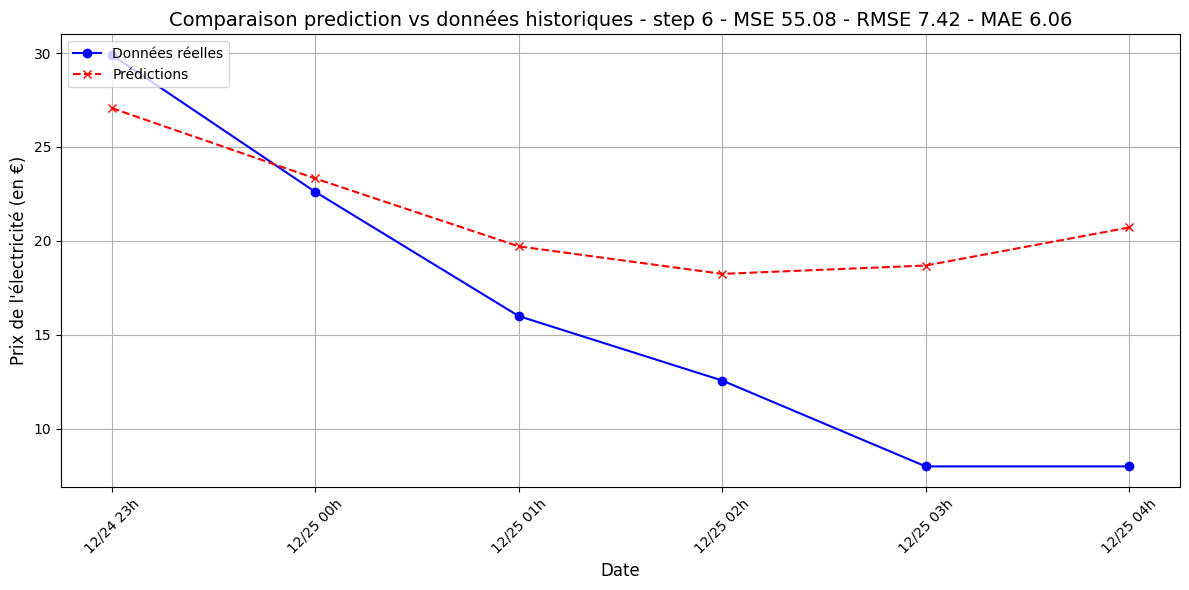

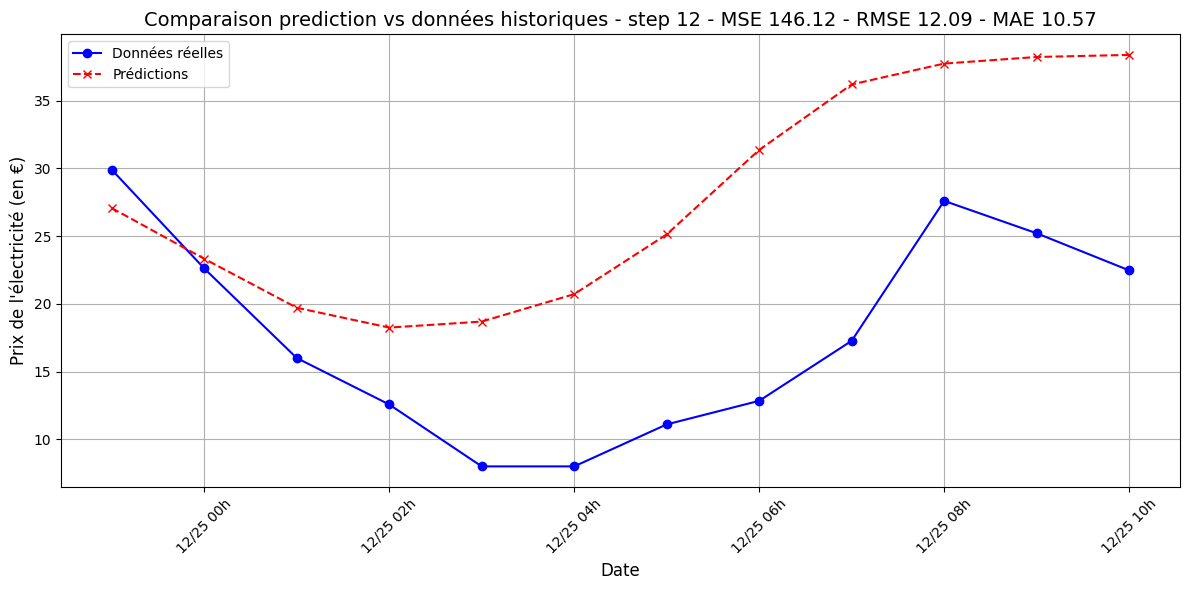

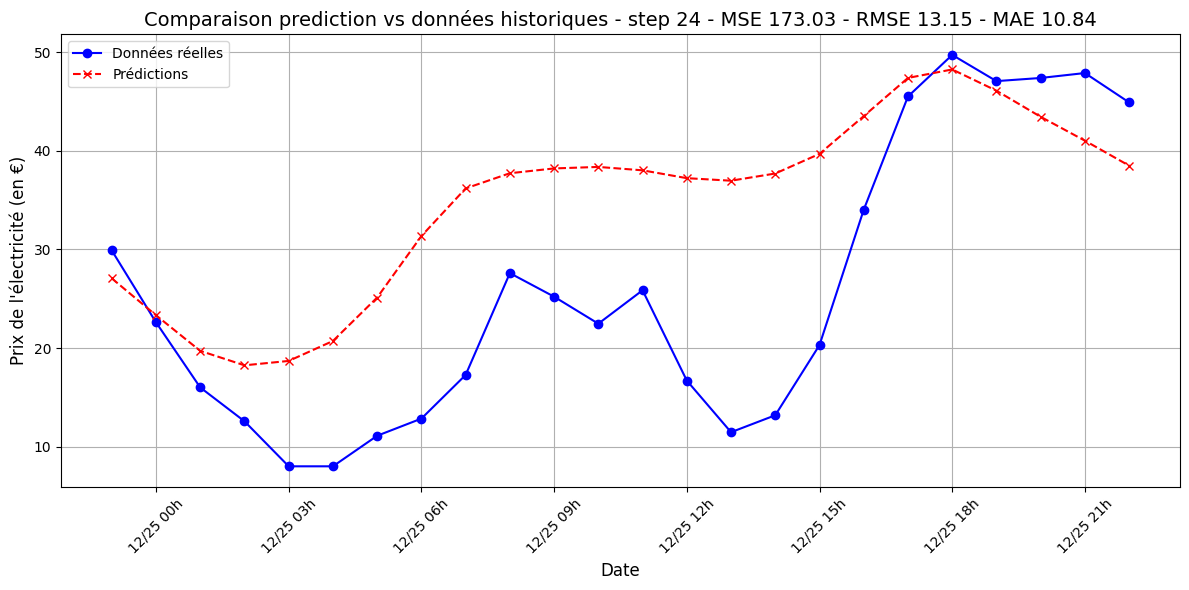

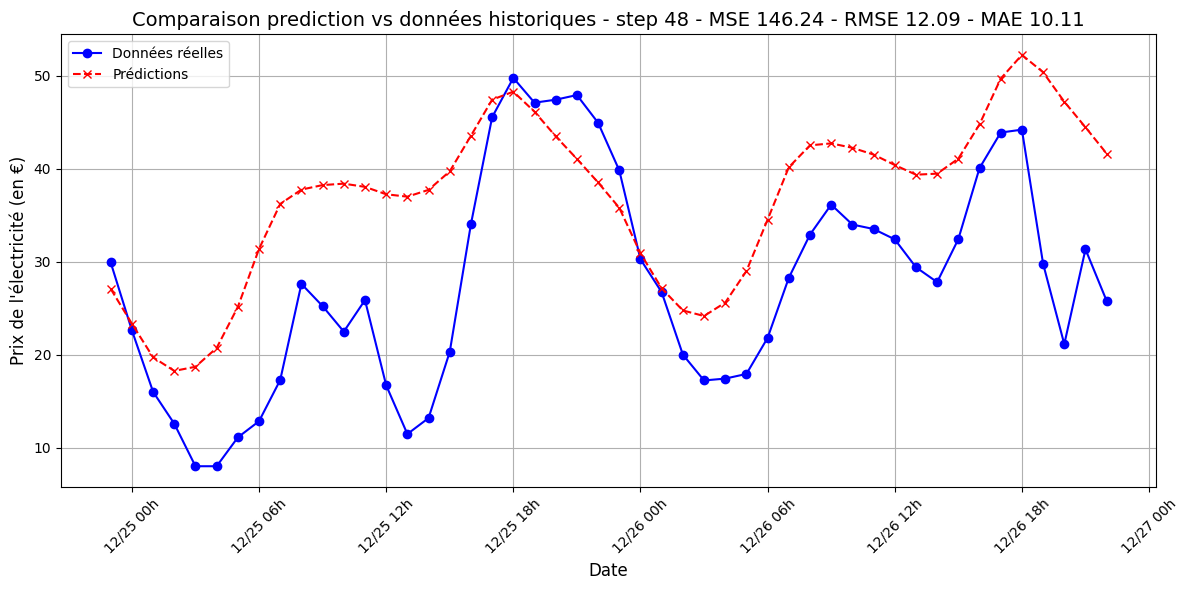

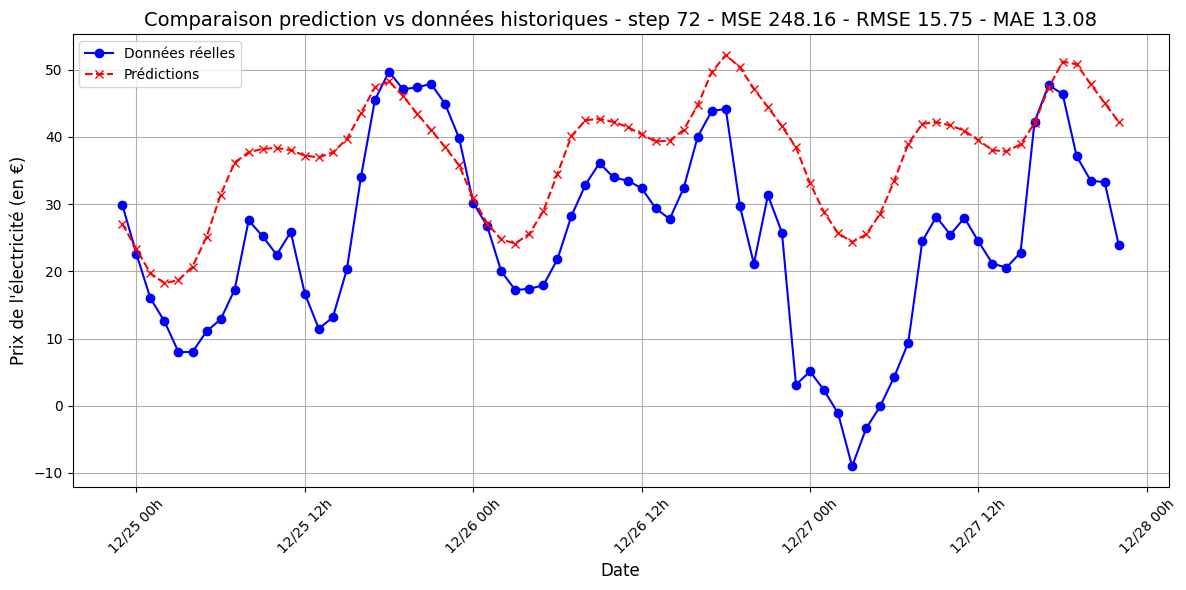

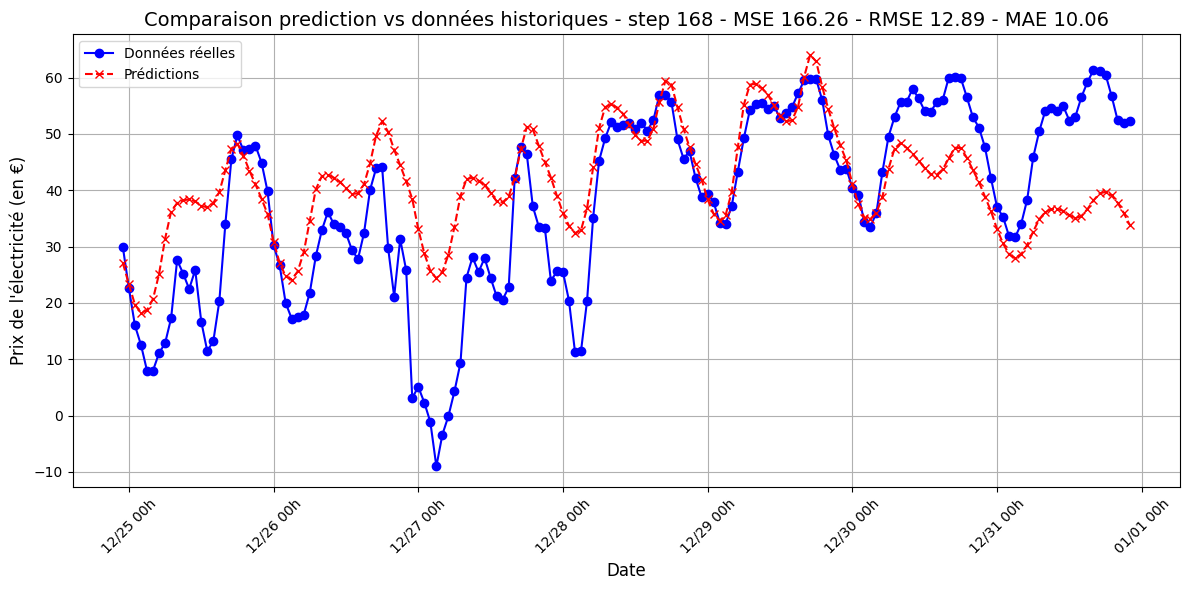

In [754]:
list_step = [6, 12, 24, 48, 72, 168]    # Nb hour that you want to predict

for step in list_step:
    predictions = autoregressive_prediction(model, X_test_first, step)          # Conv1D prediction
    # print(predictions)
    plot_predictions(y_test, predictions, step)

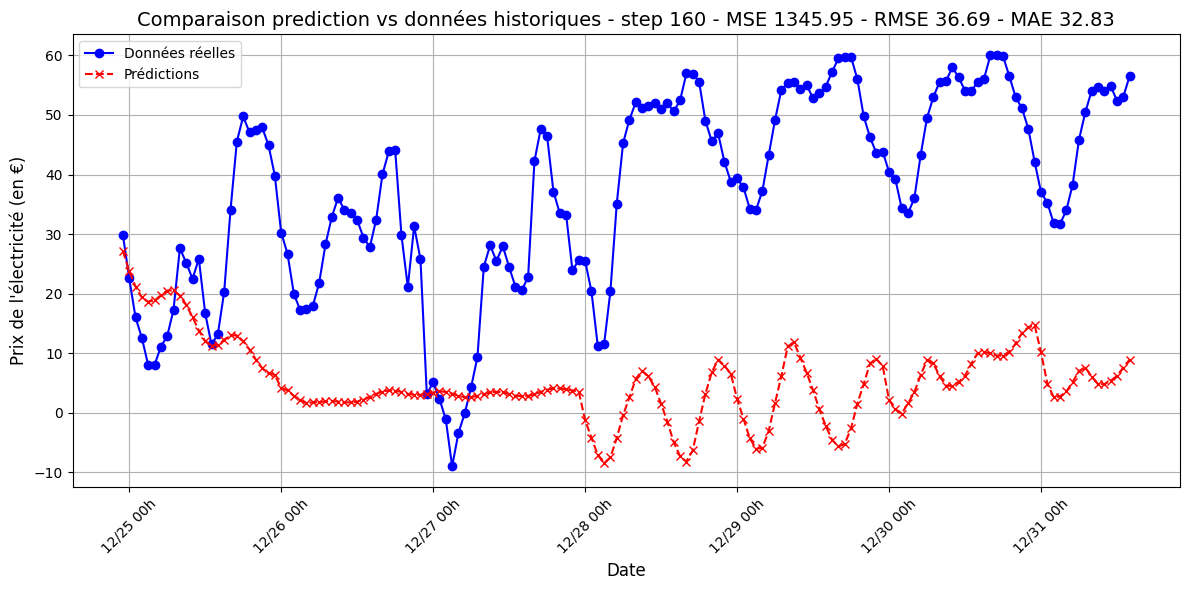

In [722]:
step = 160 

predictions = autoregressive_prediction(gru_model, X_test_first, step)      # GRU prediction
plot_predictions(y_test, predictions, step)

# Part 2: Prediction with synthetic data

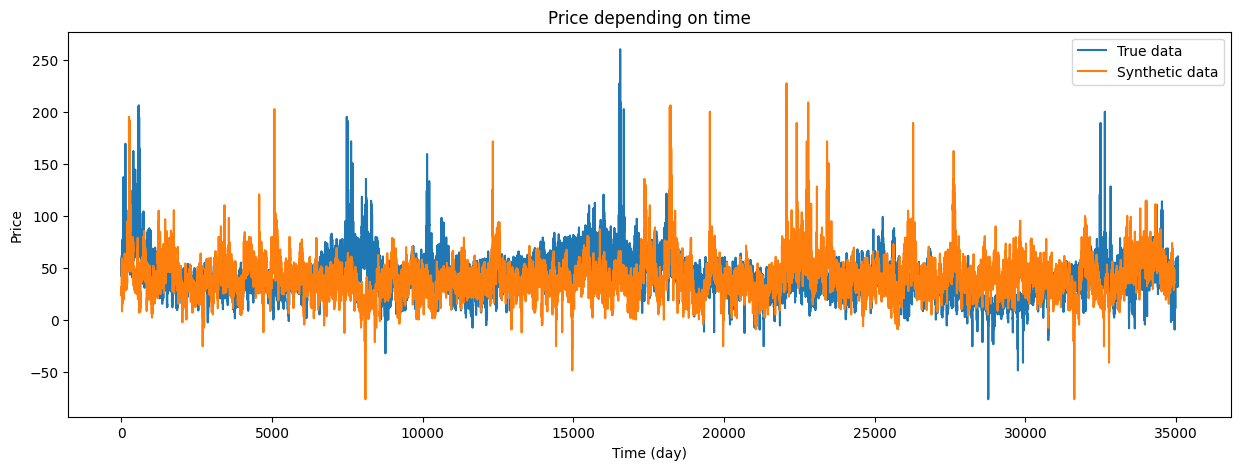

In [730]:
# Observe the appearance of synthetic data
df_price_generated_11113 = pd.read_parquet("../data/CYTECH/scenarios synthetiques/prix/11113.parquet")

plt.figure(figsize=(15,5))
plt.plot(df_price_preprocessed["price"], label="True data")
plt.plot(df_price_generated_11113["price"], label="Synthetic data")
plt.title('Price depending on time')
plt.xlabel('Time (day)')
plt.ylabel('Price')
plt.legend()

plt.show()

### Data preprocessing

In [727]:
# This function is used to generate columns of contextual data useful for prediction
def preprocess_synthetic_data(df):
    new_df = df.copy()
    
    new_df['dayofseries'] = (new_df.index // 24)
    new_df['dayofyear'] = (new_df['dayofseries'] % 365) + 1
    new_df["hoursofseries"] = new_df["dayofseries"] * 24 + new_df["hourofday"]
    
    return new_df


In [489]:
# Transform all synthetic data into a format understandable by the model
def create_input_output(df, window_size):
    X = []
    y = []
    
    # X = n last price, day of the week, time, day of the year (data context of the day/hour that we wish to predict)
    for i in range(window_size, len(df)):
        
        # Retrieve the 12 last price
        x_data = df.iloc[i-window_size:i][['price']].values.flatten()
    
        # Data context of the hour predicted
        x_data = np.concatenate([x_data, [df.iloc[i]['dayofweek'], df.iloc[i]['hourofday'], df.iloc[i]['dayofyear']]])
        
        # y : price of the next hour
        y.append(df.iloc[i]['price'])
        
        X.append(x_data)
    
    return X, y

In [490]:
# Function to load all synthetic file
def process_multiple_files(file_list, window_size):
    all_X = []
    all_y = []
    
    for file in tqdm(file_list):
        # Load file
        df = pd.read_parquet(file)
        
        # Preprocessing (add columns)
        df = preprocess_synthetic_data(df)
        
        # Prepare X and y for the model
        X, y = create_input_output(df, window_size)
        
        # Adds the data of the processed file to that of the previous files
        all_X.append(X)
        all_y.append(y)
        
    return np.array(all_X), np.array(all_y)

In [72]:
# List all file .parquet in the directory
def get_csv_files_from_directory(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.parquet')]

# directory where there are synthetic file
directory = r"..\data\CYTECH\scenarios synthetiques\prix"
file_list = get_csv_files_from_directory(directory)

all_X, all_y = process_multiple_files(file_list, window_size)

100%|██████████| 154/154 [46:02<00:00, 17.94s/it]


In [73]:
all_X = np.concatenate(all_X, axis=0)
all_y = np.concatenate(all_y, axis=0)

In [759]:
print(all_X)
print(all_y)

[[ 31.66  31.06  27.81 ...   0.    12.     1.  ]
 [ 31.06  27.81  27.54 ...   0.    13.     1.  ]
 [ 27.81  27.54  25.04 ...   0.    14.     1.  ]
 ...
 [ 29.04  30.48  26.47 ...   6.    21.   361.  ]
 [ 30.48  26.47  21.58 ...   6.    22.   361.  ]
 [ 26.47  21.58  13.89 ...   6.    23.   361.  ]]
[23.79 26.21 27.56 ... 31.57 32.57 30.74]


In [761]:
# Function to create the Conv1D model architecture
def create_conv1d_model2(input_shape):
    model2 = Sequential()
    model2.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model2.add(Flatten())
    model2.add(Dense(64, activation='relu'))
    model2.add(Dense(1))  # Output = price of the next hour
    
    model2.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model2

In [762]:
# Create model
input_shape = (all_X.shape[1], 1)
model2 = create_conv1d_model2(input_shape)

model2.summary()

c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_57 (Conv1D)              │ (None, 13, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_53 (Flatten)            │ (None, 832)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 64)             │        53,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,633 (209.50 KB)

 Trainable params: 53,633 (209.50 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [763]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

X_train_reshaped = all_X.reshape(all_X.shape[0], all_X.shape[1], 1)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_reshaped, all_y, test_size=0.2, random_state=42)      # Split (validation, train)

# Avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Entraîner le modèle avec les données de validation
history = model2.fit(
    X_train_split, y_train_split,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_split, y_val_split),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/20
134489/134489 ━━━━━━━━━━━━━━━━━━━━ 414s 3ms/step - loss: 18.8705 - mae: 2.8322 - val_loss: 13.6692 - val_mae: 2.4694
Epoch 2/20
134489/134489 ━━━━━━━━━━━━━━━━━━━━ 370s 3ms/step - loss: 13.7756 - mae: 2.4919 - val_loss: 12.7769 - val_mae: 2.4046
Epoch 3/20
134489/134489 ━━━━━━━━━━━━━━━━━━━━ 374s 3ms/step - loss: 12.6205 - mae: 2.4037 - val_loss: 11.5260 - val_mae: 2.3256
Epoch 4/20
134489/134489 ━━━━━━━━━━━━━━━━━━━━ 367s 3ms/step - loss: 11.9367 - mae: 2.3634 - val_loss: 11.1974 - val_mae: 2.3097
Epoch 5/20
134489/134489 ━━━━━━━━━━━━━━━━━━━━ 356s 3ms/step - loss: 11.5288 - mae: 2.3368 - val_loss: 10.8356 - val_mae: 2.2909
Epoch 6/20
134489/134489 ━━━━━━━━━━━━━━━━━━━━ 360s 3ms/step - loss: 11.2374 - mae: 2.3137 - val_loss: 11.0048 - val_mae: 2.3195
Epoch 7/20
134489/134489 ━━━━━━━━━━━━━━━━━━━━ 359s 3ms/step - loss: 10.9901 - mae: 2.2950 - val_loss: 11.9439 - val_mae: 2.3348
Epoch 8/20
134489/134489 ━━━━━━━━━━━━━━━━━━━━ 356s 3ms/step - loss: 10.7909 - mae: 2.2788 - val_loss: 11

In [767]:
# Use to save the trained model
model2.save_weights('model2_weights.weights.h5')

In [757]:
model2 = create_conv1d_model(input_shape)

# Load model
model2.load_weights('model2_weights.weights.h5')

c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


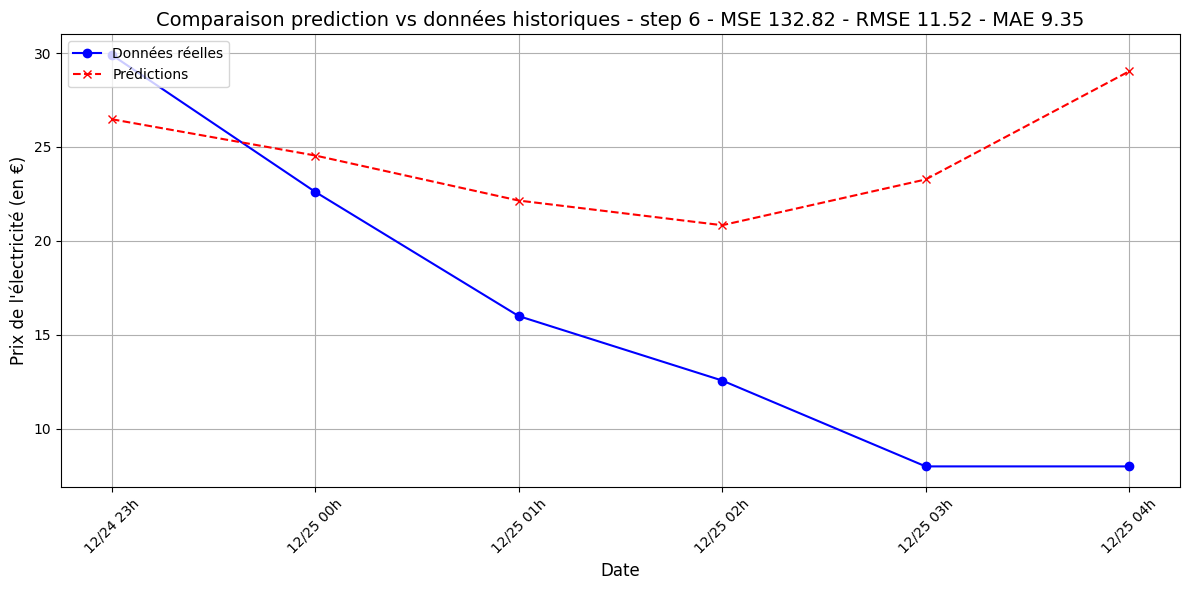

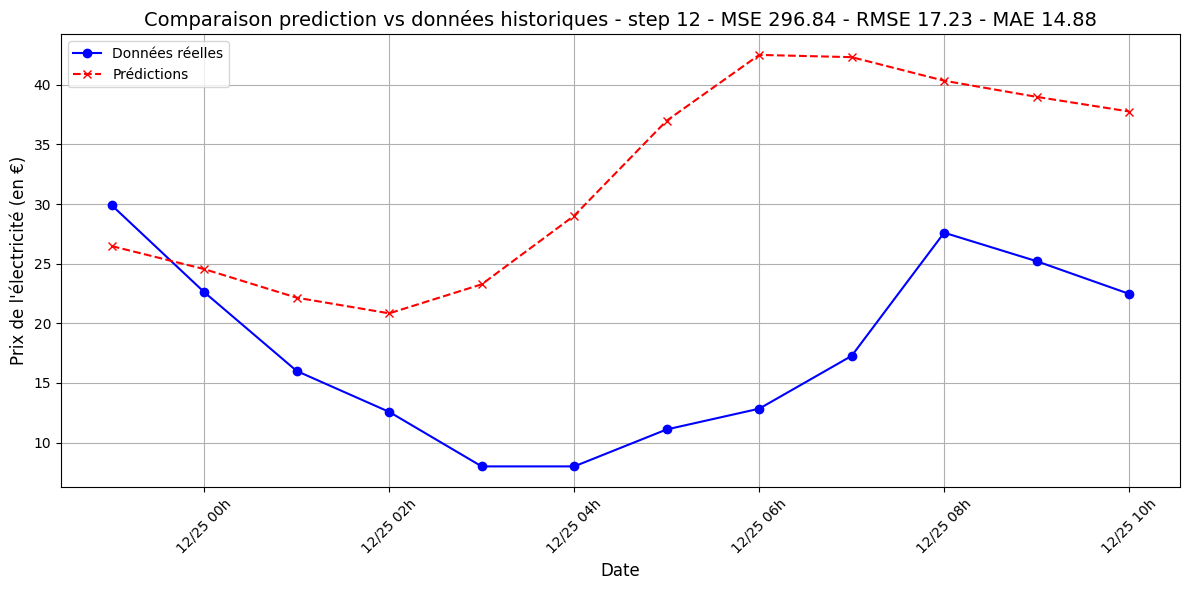

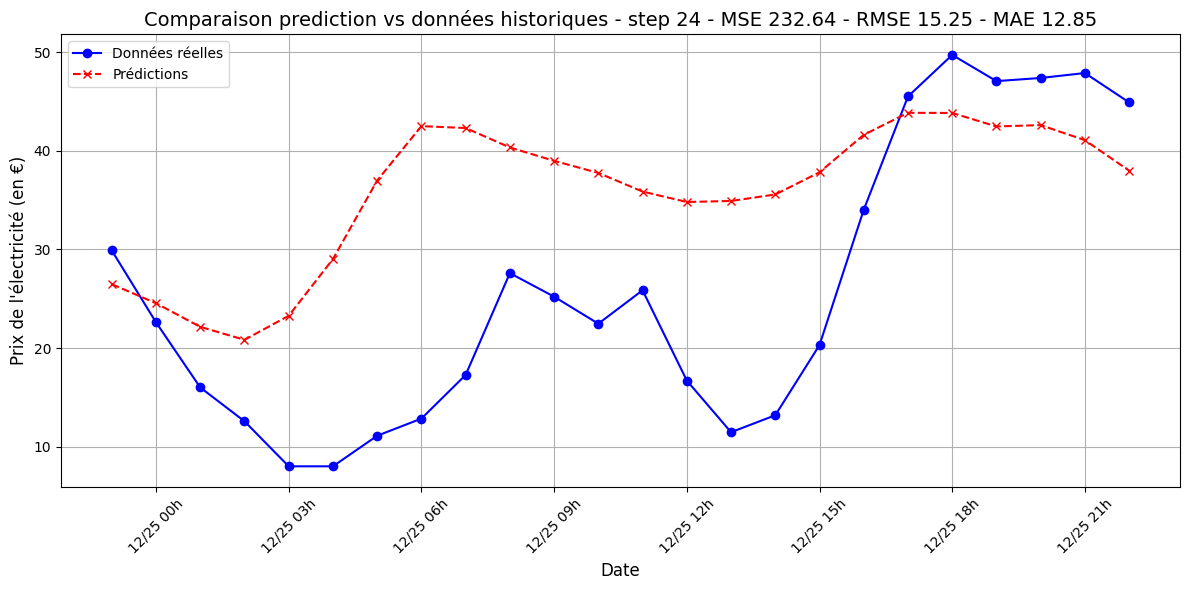

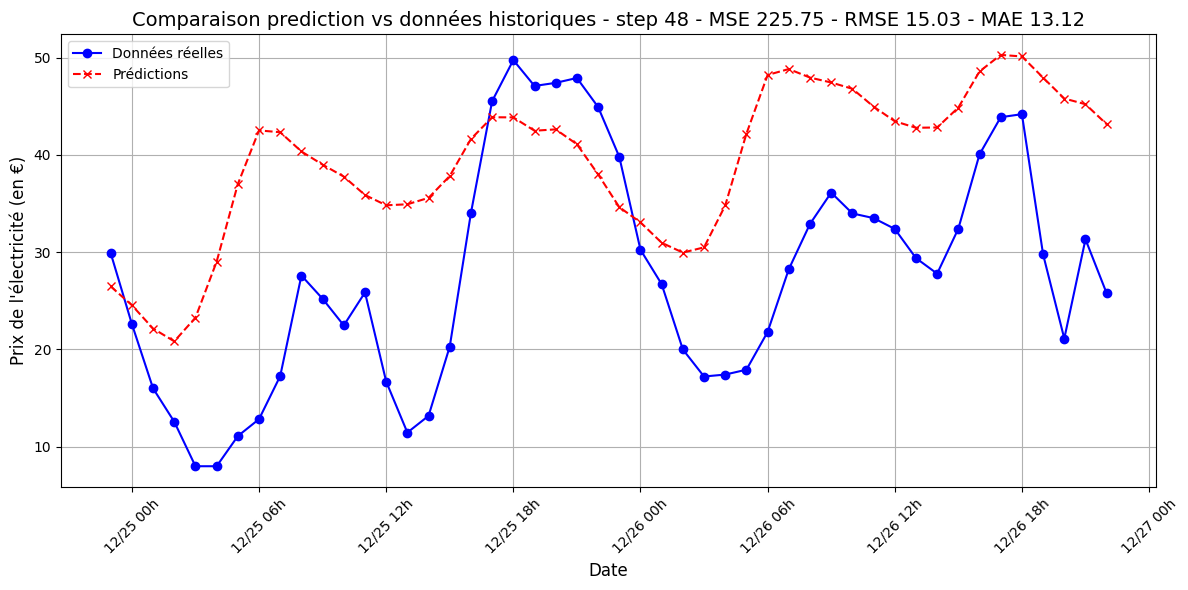

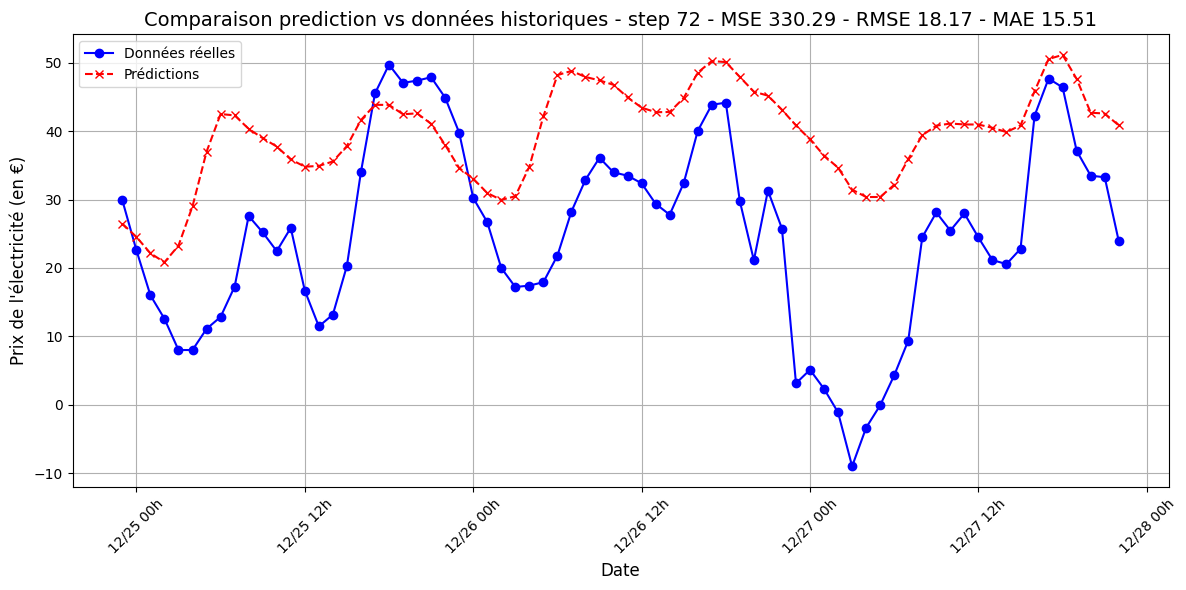

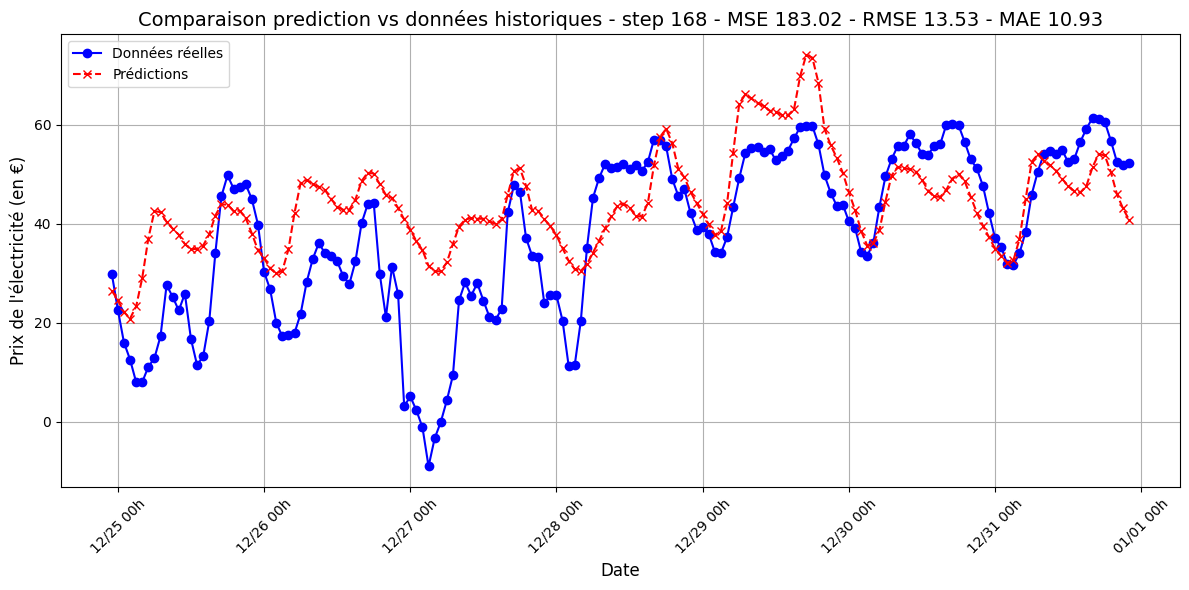

In [764]:
list_step = [6, 12, 24, 48, 72, 168]    # Nb hour that you want to predict

for step in list_step:
    predictions = autoregressive_prediction(model2, X_test_first, step)          # Conv1D prediction
    plot_predictions(y_test, predictions, step)